In [59]:
import numpy as np
from cp import unfold
import torch
from torch import nn
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
rank10 = np.load('rank10.npy')
rank50 = np.load('rank50.npy')
rank100 = np.load('rank100.npy')

In [2]:
class TensorData:
    def __init__(self,observation,label):
        self.observation = observation[:500]
        self.label = label
        self.device = torch.device("cuda:0")
    def getObservation(self):
        return self.observation
    def getLabel(self):
        return self.label
    def to(self,device):
        self.observation.to(device)
        self.label.to(device)

In [45]:
def generateDataset(tensorSet):
    observation10=[]
    for i in tensorSet:
        randomNum = np.sort(np.random.choice(np.arange(1000),500,replace=False))[::-1]
        observation10.append(np.append(np.delete(i.flatten(),randomNum),500*[0]))
    observation10=np.array(observation10)
    label10=[i.flatten() for i in tensorSet]
    # dataset = [TensorData(observation10[i],label10[i]) for i in np.arange(len(observation10))]
    dataset10 = np.array(list(zip(observation10,label10)))
    return dataset

In [55]:
dataset10 = generateDataset(rank10)
dataset50 = generateDataset(rank50)
dataset100 = generateDataset(rank100)

In [47]:
class VariationalAutoencoder10(nn.Module):
    def __init__(self,l1=750,l2=70):
        self.l1=l1
        self.l2=l2
        super(VariationalAutoencoder10, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(500, l1),
            nn.ReLU(True),
            nn.Linear(l1, l2))
        self.decoder = nn.Sequential(
            nn.Linear(l2//2, l1),
            nn.ReLU(True),
            nn.Linear(l1,1000),
            nn.Sigmoid())
    
    # sample step for z
    # mu is mean value
    # logvar is log(variance)
    def reparametrize(self, mu, logvar):
        var = logvar.exp()
        std = var.sqrt()
        eps = Variable(torch.FloatTensor(std.size()).normal_()).to(torch.device("cpu"))
        return eps.mul(std).add(mu)

    def forward(self, x):
        h = self.encoder(x)
        # encoder output size 40 vector
        mu = h[:, :self.l2//2]
        logvar = h[:, self.l2//2:]
        z = self.reparametrize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

In [48]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

num_epochs = 300
batch_size = 2
learning_rate = 0.05
trainloader10 = torch.utils.data.DataLoader(dataset10[:70], batch_size=batch_size, shuffle=True)
testloader10 = torch.utils.data.DataLoader(dataset10[70:], batch_size=batch_size, shuffle=True)
trainloader50 = torch.utils.data.DataLoader(dataset50[:70], batch_size=batch_size, shuffle=True)
testloader50 = torch.utils.data.DataLoader(dataset50[70:], batch_size=batch_size, shuffle=True)
trainloader100 = torch.utils.data.DataLoader(dataset100[:70], batch_size=batch_size, shuffle=True)
testloader100 = torch.utils.data.DataLoader(dataset100[70:], batch_size=batch_size, shuffle=True)

In [52]:
def train(trainset,path,l1=32,l2=8,learning_rate=0.05,batch_size = 2,num_epochs=300):
    model10 = VariationalAutoencoder10(l1=l1,l2=l2).to(device)
    # model10 = VariationalAutoencoder10(l1=32,l2=8)
    BCE = nn.BCELoss()
    optimizer = torch.optim.Adam(
        model10.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        for data in trainset:
            observations = torch.tensor(data[:,0,:])
            delete0observations = torch.tensor(observations[:,:500])
            labels = torch.tensor(data[:,1,:])
            delete0observations  = Variable(delete0observations.to(device).float())
            labels =  Variable(labels.to(device).float())
    #         delete0observations  = delete0observations.float()
    #         labels =  labels.float()
            # print(data[0].shape)
            # ===================forward=====================
            x_hat, mu, logvar = model10(delete0observations)
            NKLD = mu.pow(2).add(logvar.exp()).mul(-1).add(logvar.add(1))
            KLD = torch.sum(NKLD).mul(-0.5)
            KLD /= batch_size * data[0].shape[0]
            loss = BCE(x_hat, labels) + KLD
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print('epoch [{}/{}], loss:{:.4f}'
              .format(epoch + 1, num_epochs, loss.item()))
        if epoch % 10 == 0:
            batch = iter(trainloader10).next()[0]
            batch = batch.view(batch.size(0), -1)
            batch = Variable(batch)
            x_one = batch[0:1]
            x_two = batch[1:2]
    torch.save(model10.state_dict(), path)
    return model10

In [130]:
def test(model,testloader,title):
    norm10=[]
    mse10=[]
    for data in testloader:
        observations = data[:,0,:]
        delete0observations = observations[:,:500]
        labels = data[:,1,:]
        delete0observations  = Variable(delete0observations.to(device).float())
        labels =  Variable(labels.to(device).float())
        x_hat, mu, logvar = model(delete0observations)
        x_hat = x_hat.cpu().detach().numpy()
        for i in np.arange(len(x_hat)):
            mse10.append(mean_squared_error(x_hat[i],labels[i]))
            norm10.append(np.linalg.norm(x_hat[i]-labels[i].cpu().detach().numpy()))
    print('# Tests', len(norm10))
    print('median norm', np.median(norm10))
    print('total rmse',np.sqrt(sum(mse10)/len(mse10)))
    print('median RMSE',np.median(np.sqrt(np.array(mse10))))
    print('mean RMSE',np.mean(np.sqrt(np.array(mse10))))
    plt.ylabel('RMSE')
    subtitle = 'VAE Tensor Completion for 10*10*10 with true cp rank '+ title
    plt.suptitle(subtitle)
    plt.boxplot(np.sqrt(np.array(mse10)))
    plt.show()

<ipython-input-52-b034c84a3de6>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  observations = torch.tensor(data[:,0,:])
<ipython-input-52-b034c84a3de6>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  delete0observations = torch.tensor(observations[:,:500])
<ipython-input-52-b034c84a3de6>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data[:,1,:])


epoch [1/300], loss:23.6599
epoch [2/300], loss:22.8021
epoch [3/300], loss:22.1415
epoch [4/300], loss:20.7717
epoch [5/300], loss:20.1348
epoch [6/300], loss:19.1180
epoch [7/300], loss:18.3429
epoch [8/300], loss:16.9271
epoch [9/300], loss:15.9930
epoch [10/300], loss:14.7831
epoch [11/300], loss:13.9324
epoch [12/300], loss:12.6478
epoch [13/300], loss:11.8218
epoch [14/300], loss:10.9480
epoch [15/300], loss:9.6428
epoch [16/300], loss:9.0896
epoch [17/300], loss:8.2221
epoch [18/300], loss:7.6834
epoch [19/300], loss:6.6552
epoch [20/300], loss:5.7778
epoch [21/300], loss:5.1224
epoch [22/300], loss:4.6788
epoch [23/300], loss:4.0650
epoch [24/300], loss:3.5405
epoch [25/300], loss:3.0115
epoch [26/300], loss:2.5468
epoch [27/300], loss:2.1303
epoch [28/300], loss:1.6862
epoch [29/300], loss:1.2055
epoch [30/300], loss:0.8634
epoch [31/300], loss:0.7126
epoch [32/300], loss:0.7230
epoch [33/300], loss:0.7010
epoch [34/300], loss:0.7024
epoch [35/300], loss:0.7040
epoch [36/300],

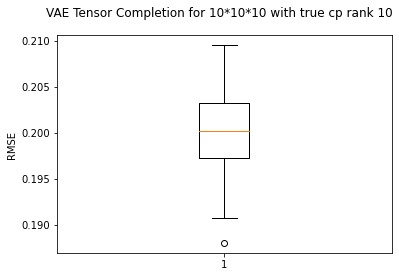

In [131]:
model10 = train(trainloader10,path='./vae_completion_10.pth')
test(model10,testloader10,'10')

<ipython-input-52-b034c84a3de6>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  observations = torch.tensor(data[:,0,:])
<ipython-input-52-b034c84a3de6>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  delete0observations = torch.tensor(observations[:,:500])
<ipython-input-52-b034c84a3de6>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data[:,1,:])


epoch [1/300], loss:8.3163
epoch [2/300], loss:1.4270
epoch [3/300], loss:0.7242
epoch [4/300], loss:0.7132
epoch [5/300], loss:0.7005
epoch [6/300], loss:0.7436
epoch [7/300], loss:0.7033
epoch [8/300], loss:0.7535
epoch [9/300], loss:0.7014
epoch [10/300], loss:0.6975
epoch [11/300], loss:0.7004
epoch [12/300], loss:0.7107
epoch [13/300], loss:0.6993
epoch [14/300], loss:0.6971
epoch [15/300], loss:0.7024
epoch [16/300], loss:0.7008
epoch [17/300], loss:0.6963
epoch [18/300], loss:0.6975
epoch [19/300], loss:0.6990
epoch [20/300], loss:0.6971
epoch [21/300], loss:0.6976
epoch [22/300], loss:0.6955
epoch [23/300], loss:0.6966
epoch [24/300], loss:0.6965
epoch [25/300], loss:0.6963
epoch [26/300], loss:0.6957
epoch [27/300], loss:0.6962
epoch [28/300], loss:0.6987
epoch [29/300], loss:0.6993
epoch [30/300], loss:0.7010
epoch [31/300], loss:0.6959
epoch [32/300], loss:0.6985
epoch [33/300], loss:0.6962
epoch [34/300], loss:0.6990
epoch [35/300], loss:0.6994
epoch [36/300], loss:0.7016
e

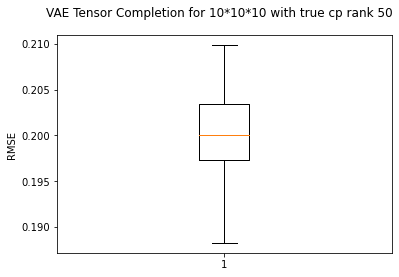

In [132]:
model50 = train(trainloader50,path='./vae_completion_50.pth')
test(model50,testloader50,'50')

<ipython-input-52-b034c84a3de6>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  observations = torch.tensor(data[:,0,:])
<ipython-input-52-b034c84a3de6>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  delete0observations = torch.tensor(observations[:,:500])
<ipython-input-52-b034c84a3de6>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data[:,1,:])


epoch [1/300], loss:0.6983
epoch [2/300], loss:0.6953
epoch [3/300], loss:0.6949
epoch [4/300], loss:0.6950
epoch [5/300], loss:0.6939
epoch [6/300], loss:0.6949
epoch [7/300], loss:0.6942
epoch [8/300], loss:0.6944
epoch [9/300], loss:0.6940
epoch [10/300], loss:0.6935
epoch [11/300], loss:0.6940
epoch [12/300], loss:0.6946
epoch [13/300], loss:0.6947
epoch [14/300], loss:0.6933
epoch [15/300], loss:0.6951
epoch [16/300], loss:0.6945
epoch [17/300], loss:0.6949
epoch [18/300], loss:0.6943
epoch [19/300], loss:0.6941
epoch [20/300], loss:0.6950
epoch [21/300], loss:0.6942
epoch [22/300], loss:0.6951
epoch [23/300], loss:0.6946
epoch [24/300], loss:0.6940
epoch [25/300], loss:0.6954
epoch [26/300], loss:0.6945
epoch [27/300], loss:0.6949
epoch [28/300], loss:0.6941
epoch [29/300], loss:0.6936
epoch [30/300], loss:0.6942
epoch [31/300], loss:0.6938
epoch [32/300], loss:0.6945
epoch [33/300], loss:0.6950
epoch [34/300], loss:0.6932
epoch [35/300], loss:0.6939
epoch [36/300], loss:0.6945
e

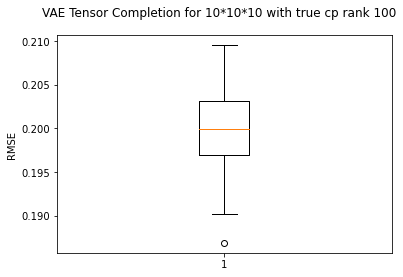

In [133]:
model100 = train(trainloader100,learning_rate=0.03,path='./vae_completion_100.pth')
test(model100,testloader100,'100')

# Tests 30
total rmse 0.19975340164178226
median RMSE 0.20025095
mean RMSE 0.19968866
mean norm 6.31471


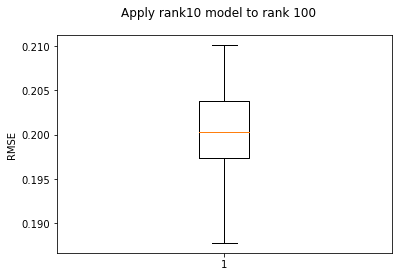

In [127]:
norm100=[]
mse100=[]
for data in testloader100:
    observations = data[:,0,:]
    delete0observations = observations[:,:500]
    labels = data[:,1,:]
    delete0observations  = Variable(delete0observations.to(device).float())
    labels =  Variable(labels.to(device).float())
    x_hat, mu, logvar = model10(delete0observations)
    x_hat = x_hat.cpu().detach().numpy()
    for i in np.arange(len(x_hat)):
#         print(x_hat[i])
#         print(labels[i])
        mse100.append(mean_squared_error(x_hat[i],labels[i]))
        norm100.append(np.linalg.norm(x_hat[i]-labels[i].cpu().detach().numpy()))
print('# Tests', len(norm100))
print('total rmse',np.sqrt(sum(mse100)/len(mse100)))
print('median RMSE',np.median(np.sqrt(np.array(mse100))))
print('mean RMSE',np.mean(np.sqrt(np.array(mse100))))
print('mean norm', np.mean(norm100))
plt.ylabel('RMSE')
subtitle = 'Apply rank10 model to rank 100'
plt.suptitle(subtitle)
plt.boxplot(np.sqrt(np.array(mse100)))
plt.show()

In [102]:
np.shape(np.array(list(model10.parameters())))

(8,)

In [111]:
np.linalg.norm(torch.cat([param.view(-1) for param in model10.parameters()]).detach().numpy()-torch.cat([param.view(-1) for param in model100.parameters()]).detach().numpy())
mean_squared_error(torch.cat([param.view(-1) for param in model10.parameters()]).detach().numpy(),torch.cat([param.view(-1) for param in model100.parameters()]).detach().numpy())

0.2355009

In [125]:
# mean_squared_error(dataset[10][1],dataset[0][1])
np.linalg.norm(dataset[10][1]-dataset[0][1])

8.996637229614906